In [1]:
import numpy as np
import stim
from matplotlib import pyplot as plt

## Basic circuit

In [2]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

In [3]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[ True  True]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]]


## Detector annotations

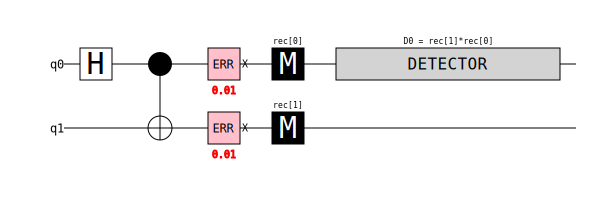

In [4]:
error_p = 0.01
circuit = stim.Circuit()
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])
circuit.append("X_ERROR", [0, 1], error_p)
circuit.append("M", [0, 1])
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
circuit.diagram("timeline-svg")

In [5]:
shots = 10**6

sampler = circuit.compile_sampler()
res1 = sampler.sample(shots)
print(np.unique(res1, return_counts=True, axis=0))

sampler = circuit.compile_detector_sampler()
res1 = sampler.sample(shots)
print(np.unique(res1, return_counts=True))
print(np.sum(res1) / shots, 2 * error_p * (1 - error_p))

(array([[False, False],
       [False,  True],
       [ True, False],
       [ True,  True]]), array([490646,   9796,   9938, 489620]))
(array([False,  True]), array([980067,  19933]))
0.019933 0.0198


## Repetition code: DEF

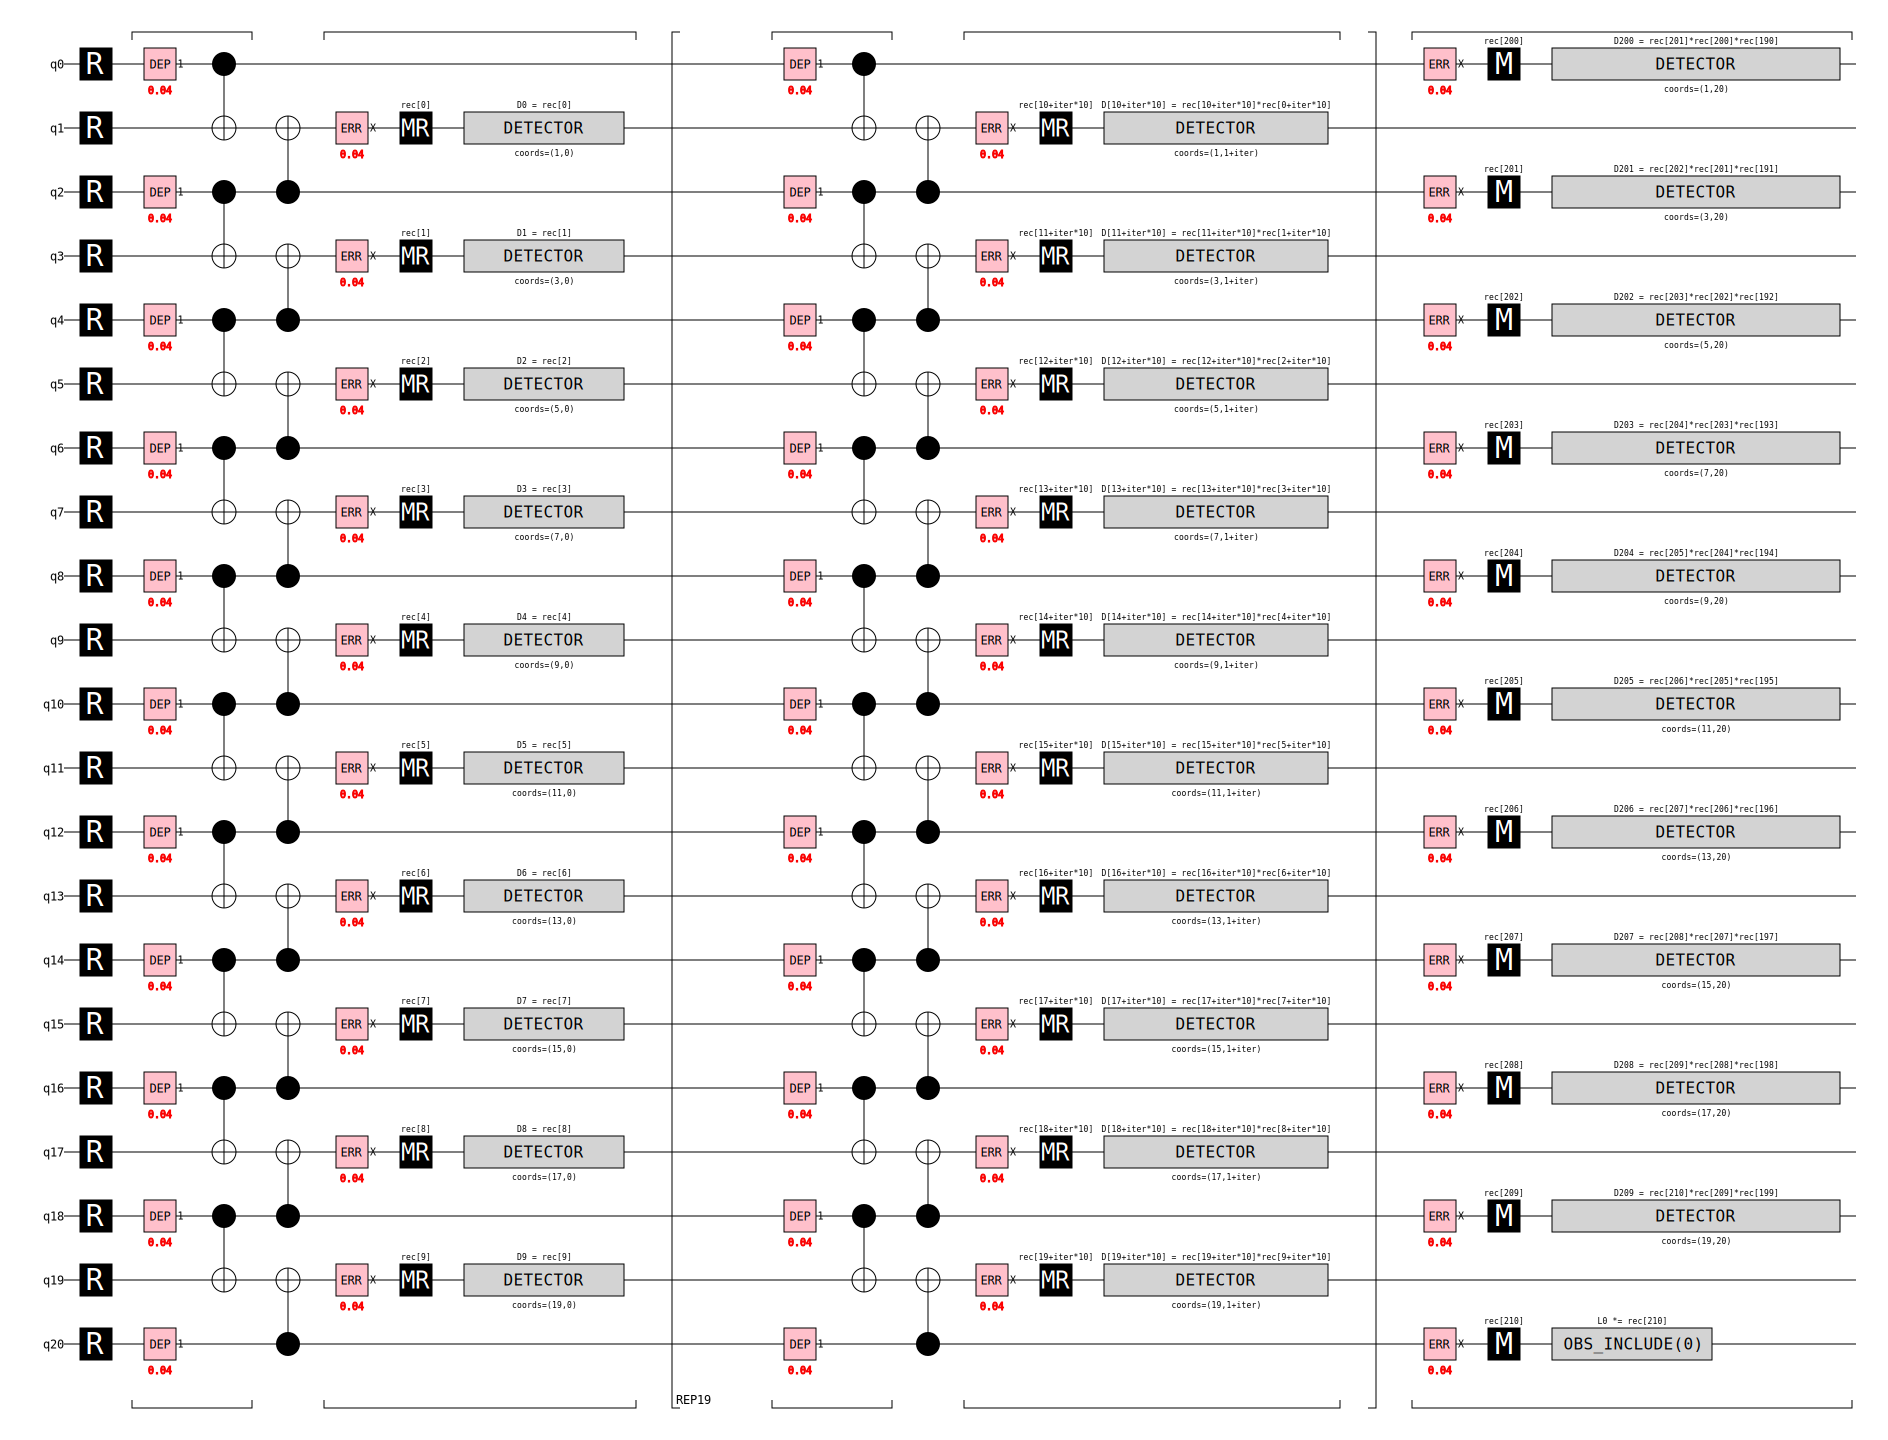

In [6]:
distance = 11
rounds = 20
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    distance=distance,
    rounds=rounds,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.04,
)
circuit.diagram("timeline-svg")

(10000, 210)
(21, 10)


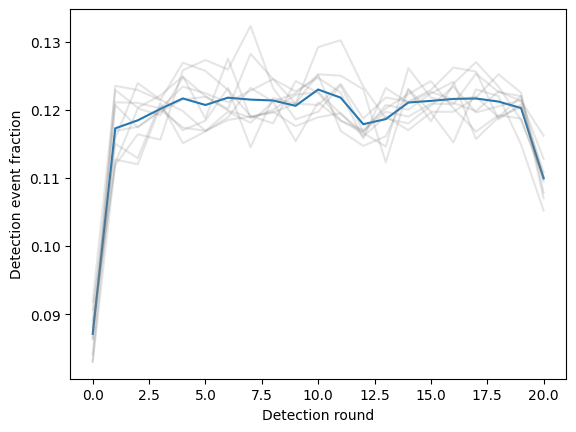

In [7]:
shots = 10**4
detector_sampler = circuit.compile_detector_sampler()
detector_sample = detector_sampler.sample(shots)
print(detector_sample.shape)

res1 = detector_sample.mean(axis=0)
res1 = res1.reshape((rounds + 1, distance - 1))
print(res1.shape)

plt.plot(res1.mean(axis=1))
plt.plot(res1, "gray", alpha=0.2)
plt.xlabel("Detection round")
plt.ylabel("Detection event fraction")
plt.show()

## Repetition code: correlation

In [8]:
res1 = np.einsum('ij,ik->ijk', detector_sample, detector_sample).mean(axis=0)
res1.shape

(210, 210)

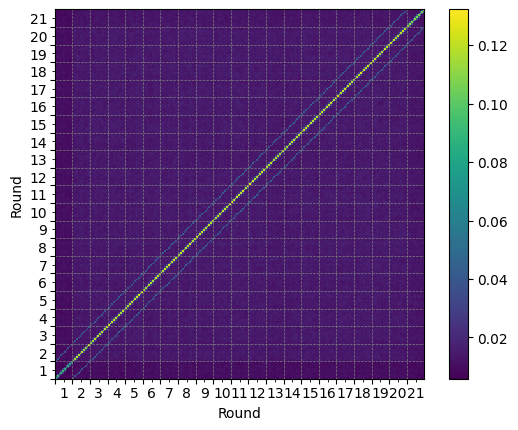

In [9]:
plt.imshow(res1, interpolation="none")
plt.colorbar()
plt.xlabel("Round")
plt.ylabel("Round")

ax = plt.gca()
ax.invert_yaxis()

ticks = np.arange(rounds + 1) * (distance - 1) - 0.5
labels = [i + 1 for i in range(rounds + 1)]

ax.set_xticks(ticks, [])
ax.set_xticks(ticks + (distance - 1) / 2, labels, minor=True)
ax.set_yticks(ticks, [])
ax.set_yticks(ticks + (distance - 1) / 2, labels, minor=True)

# ax.set_yticks(ticks, labels, minor=True)
ax.grid(which="major", color="gray", linestyle="--", linewidth=0.5)

plt.show()

In [10]:
res1

array([[0.0881, 0.0301, 0.0095, ..., 0.0101, 0.008 , 0.0094],
       [0.0301, 0.0906, 0.0286, ..., 0.0091, 0.0088, 0.0086],
       [0.0095, 0.0286, 0.0863, ..., 0.0078, 0.0074, 0.0084],
       ...,
       [0.0101, 0.0091, 0.0078, ..., 0.1101, 0.038 , 0.0125],
       [0.008 , 0.0088, 0.0074, ..., 0.038 , 0.1052, 0.0388],
       [0.0094, 0.0086, 0.0084, ..., 0.0125, 0.0388, 0.1098]])

In [11]:
res2 = np.einsum('ijkl -> jilk', res1.reshape((rounds + 1, distance - 1, rounds + 1, distance - 1)))
res2 = res2.reshape((rounds + 1) * (distance - 1), (rounds + 1) * (distance - 1))
res2.shape

(210, 210)

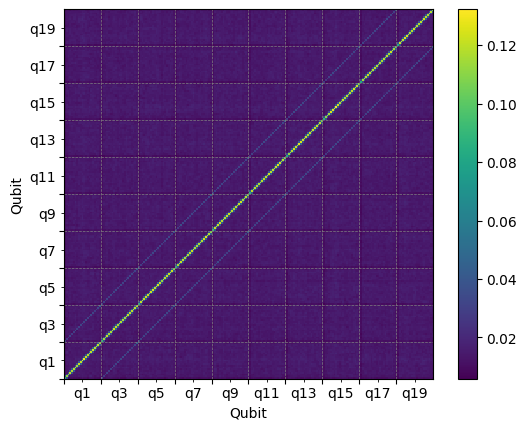

In [12]:
plt.imshow(res2, interpolation="none")
plt.colorbar()
plt.xlabel("Qubit")
plt.ylabel("Qubit")

ax = plt.gca()
ax.invert_yaxis()

ticks = np.arange(distance - 1) * (rounds + 1) - 0.5
labels = [f"q{i * 2 + 1}" for i in range(distance - 1)]

ax.set_xticks(ticks, [])
ax.set_xticks(ticks + (rounds + 1) / 2, labels, minor=True)
ax.set_yticks(ticks, [])
ax.set_yticks(ticks + (rounds + 1) / 2, labels, minor=True)

ax.grid(which="major", color="gray", linestyle="--", linewidth=0.5)

plt.show()